I find some data leakage from the validation set. Though I am not sure whether it is intentional for it being called 'validation' set. I am actually not sure about the validation set purpose.

In [8]:
import time
script_start_time = time.time()

import pandas as pd
import numpy as np
import json
import gc

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import plotly.plotly as py
import cufflinks as cf
cf.set_config_file(offline=True, world_readable=True, theme='ggplot')
plt.rcParams["figure.figsize"] = 12,8
sns.set(rc={'figure.figsize':(20,12)})
plt.style.use('fivethirtyeight')

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)
import warnings
warnings.filterwarnings('ignore')

# Data path
data_path = './data'

### 1. Load Data
Reference: [](https://www.kaggle.com/badalgupta/simple-data-exploration)

In [9]:
# 1. Load data =================================================================
print('%0.2f min: Start loading data'%((time.time() - script_start_time)/60))
train={}
test={}
validation={}
with open('%s/train.json'%(data_path)) as json_data:
    train= json.load(json_data)
with open('%s/test.json'%(data_path)) as json_data:
    test= json.load(json_data)
with open('%s/validation.json'%(data_path)) as json_data:
    validation = json.load(json_data)

print('Train No. of images: %d'%(len(train['images'])))
print('Test No. of images: %d'%(len(test['images'])))
print('Validation No. of images: %d'%(len(validation['images'])))

# JSON TO PANDAS DATAFRAME
# train data
train_img_url=train['images']
train_img_url=pd.DataFrame(train_img_url)
train_ann=train['annotations']
train_ann=pd.DataFrame(train_ann)
train=pd.merge(train_img_url, train_ann, on='imageId', how='inner')

# test data
test=pd.DataFrame(test['images'])

# Validation Data
val_img_url=validation['images']
val_img_url=pd.DataFrame(val_img_url)
val_ann=validation['annotations']
val_ann=pd.DataFrame(val_ann)
validation=pd.merge(val_img_url, val_ann, on='imageId', how='inner')

del (train_img_url, train_ann, val_img_url, val_ann)
gc.collect()

print('%0.2f min: Finish loading data'%((time.time() - script_start_time)/60))
print('='*50)

0.04 min: Start loading data
Train No. of images: 1014544
Test No. of images: 39706
Validation No. of images: 9897
0.16 min: Finish loading data


### 2. Check Data for Missing or Duplicated Values
Findings:
a. No missing values
b. No duplicates in each data set, but val urls are from test.


In [10]:
datas = {'Train': train, 'Test': test, 'Validation': validation}

total_url = []
dataset_url = {}
for data_name, data in datas.items():
    print('%s shape: %s'%(data_name, str(data.shape)))
    print('%s Unique imageId: %s'%(data_name, len(data['imageId'].unique())))
    print('%s Unique url: %s'%(data_name, len(data['url'].unique())))
    print('%s NA: '%(data_name)) # No missing values
    print(data.isnull().sum()) # No missing values
    print('%s total unique url: %d'%(data_name, len(set(data['url'].tolist()))))
    total_url = total_url + data['url'].tolist()
    dataset_url[data_name] = data['url'].tolist()

    print('-'*50)


print('Total images: %d'%(len(total_url)))
print('Total unique images: %d'%(len(set(total_url))))
print('Duplicated url: %d'%(len(total_url) - len(set(total_url))))

Train shape: (1014544, 3)
Train Unique imageId: 1014544
Train Unique url: 1014544
Train NA: 
imageId    0
url        0
labelId    0
dtype: int64
Train total unique url: 1014544
--------------------------------------------------
Test shape: (39706, 2)
Test Unique imageId: 39706
Test Unique url: 39706
Test NA: 
imageId    0
url        0
dtype: int64
Test total unique url: 39706
--------------------------------------------------
Validation shape: (9897, 3)
Validation Unique imageId: 9897
Validation Unique url: 9897
Validation NA: 
imageId    0
url        0
labelId    0
dtype: int64
Validation total unique url: 9897
--------------------------------------------------
Total images: 1064147
Total unique images: 1054250
Duplicated url: 9897


9897? A bit familiar? Yes, same as the number of val rows. 
Still, let's create a grid to search for the duplicated the url

In [11]:
# Find the duplicated url
from itertools import product
combinations = list(product(*[datas.keys(), datas.keys()]))
for comb in combinations:
    print('%s inter %s: %d | %d'%(comb[0], comb[1], len(set(dataset_url[comb[0]])), len(set(dataset_url[comb[0]]).intersection(set(dataset_url[comb[1]])))))

Train inter Train: 1014544 | 1014544
Train inter Test: 1014544 | 0
Train inter Validation: 1014544 | 0
Test inter Train: 39706 | 0
Test inter Test: 39706 | 39706
Test inter Validation: 39706 | 9897
Validation inter Train: 9897 | 0
Validation inter Test: 9897 | 9897
Validation inter Validation: 9897 | 9897


'Test inter Validation: 39706 | 9897'
What? Val is part of test?
Let's confirm the duplicated url by merging test and val on url

In [12]:
# Confirm the duplicated url
test[['url']].merge(validation[['url']], how = 'inner').shape
test_ = test.merge(validation[['url', 'labelId']], on = 'url',how = 'left')
print('%s NA: '%('Test')) # No missing values
print(test_.isnull().sum() / test_.isnull().count())

Test NA: 
imageId    0.000000
url        0.000000
labelId    0.750743
dtype: float64


Let's which part of test are leaked

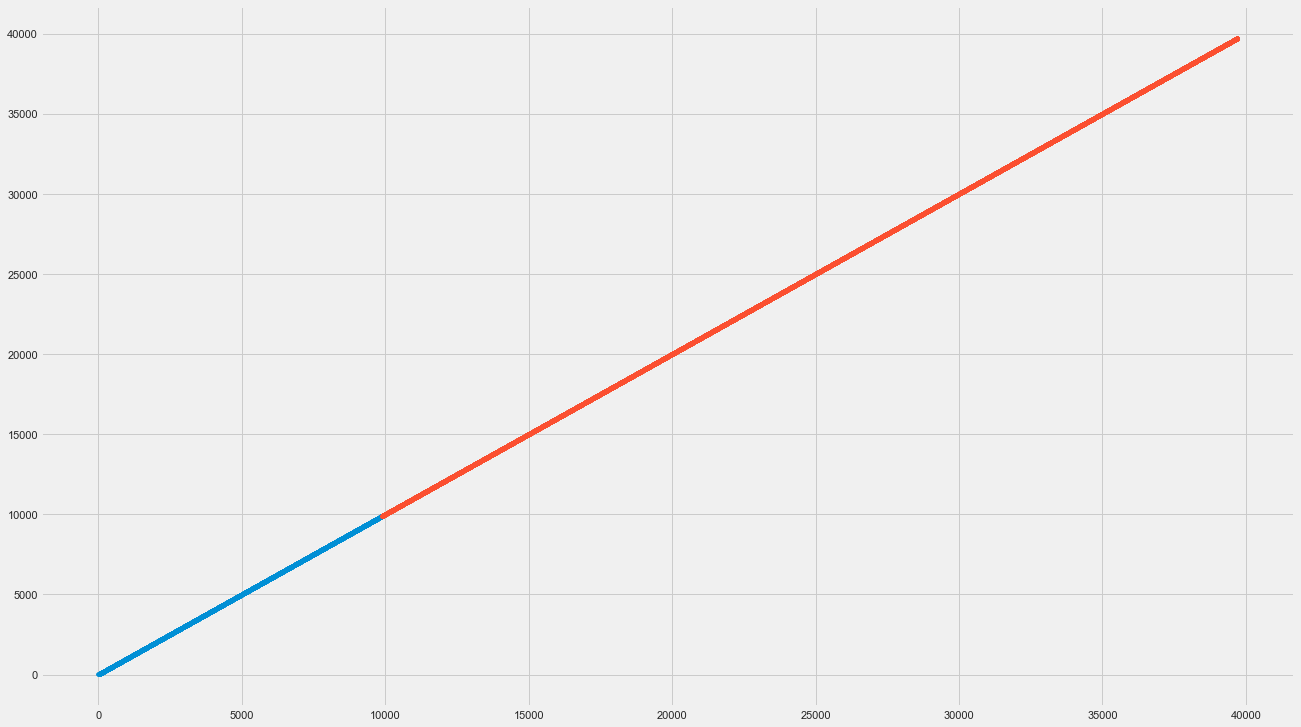

In [13]:
# Plot imageId of of leaked lable
test_leaked_lableId = test_[~pd.isna(test_['labelId'])]
test_unleaked_lableId = test_[pd.isna(test_['labelId'])]
number_of_known_lableId = validation.shape[0]
plt.plot(test_leaked_lableId['imageId'], '.')
plt.plot(test_unleaked_lableId['imageId'], '.')

Display images to confirm again the leakage

In [14]:
from IPython.display import Image
from IPython.core.display import HTML

def display_category(urls, category_name):
    img_style = "width: 180px; margin: 0px; float: left; border: 1px solid black;"
    images_list = ''.join([f"<img style='{img_style}' src='{u}' />" for _, u in urls.head(12).iteritems()])
    display(HTML(images_list))

In [15]:
#test data Images
urls = test['url'][1:5]
display_category(urls, "")

In [16]:
#validation Images
urls = validation['url'][1:5]
display_category(urls, "")

In [17]:
#train_data Images
urls = train['url'][1:5]
display_category(urls, "")

Now, we are 100% sure that the first 9897 of test set has their label id in val.